## KY Kindergarten Readiness Analysis
Education and Poverty Trends in KY Counties

In [346]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os 
import sqlite3

Load the County Health Rankings dataset from the national CSV file.  

In [347]:
# load county health rankings (national)
df = pd.read_csv("../data/analytic_data2025_v2.csv", low_memory=False)

Keep only rows where the state abbreviation is KY.

In [348]:
# Filter to Kentucky
df_chr_ky = df[df["State Abbreviation"] == "KY"]

Keep only state, county, child poverty percentage, and high school completion percentage.

In [349]:
# keep only the columns needed
columns_to_keep = [
    "State Abbreviation",
    "Name",                           # county name
    "Children in Poverty raw value",
    "High School Completion raw value"
]

df_chr_ky = df_chr_ky[columns_to_keep]
df_chr_ky.head(3)

,State Abbreviation,Name,Children in Poverty raw value,High School Completion raw value
1022,KY,Kentucky,0.202,0.8853320347
1023,KY,Adair County,0.278,0.8578791192
1024,KY,Allen County,0.215,0.8495460441


Rename all columns to lowercase, descriptive names to match other datasets.

In [350]:
# rename to match the format of other datasets
df_chr_ky.columns = [
    "state",
    "county",
    "child_poverty_pct",
    "hs_completion_pct"
]

df_chr_ky.head(3)

,state,county,child_poverty_pct,hs_completion_pct
1022,KY,Kentucky,0.202,0.8853320347
1023,KY,Adair County,0.278,0.8578791192
1024,KY,Allen County,0.215,0.8495460441


Remove " County" from county names and drop the statewide summary row.

In [351]:
df_chr_ky["county"] = df_chr_ky["county"].str.replace(" County", "", regex=False)
df_chr_ky = df_chr_ky[df_chr_ky["county"] != "Kentucky"]
df_chr_ky.head(3)

,state,county,child_poverty_pct,hs_completion_pct
1023,KY,Adair,0.278,0.8578791192
1024,KY,Allen,0.215,0.8495460441
1025,KY,Anderson,0.122,0.9169763817


Ensure percentages are stored as numeric types for calculations.

In [352]:
df_chr_ky["child_poverty_pct"] = pd.to_numeric(df_chr_ky["child_poverty_pct"], errors="coerce")
df_chr_ky["hs_completion_pct"] = pd.to_numeric(df_chr_ky["hs_completion_pct"], errors="coerce")
df_chr_ky.describe(include="all").T.head(6)

df_chr_ky.describe(include="all").T.head(6)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
state,120,1,KY,120,NaN,NaN,NaN,NaN,NaN,NaN,NaN
county,120,120,Adair,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
child_poverty_pct,120.0,NaN,NaN,NaN,0.235808,0.085694,0.05,0.17825,0.2225,0.27925,0.536
hs_completion_pct,120.0,NaN,NaN,NaN,0.851548,0.05681,0.659858,0.813814,0.854216,0.896419,0.943003


Check for missing values

In [353]:
df_chr_ky.isnull().sum()

state                0
county               0
child_poverty_pct    0
hs_completion_pct    0
dtype: int64

Load and clean childcare subsidies dataset  (2nd dataset)
Source: Kentucky KIDS COUNT  
I wanted to filter to county-level data, keep only relevant columns, clean names, and convert to numeric types.

In [354]:
# Load childcare subsidies dataset
subsidies_df = pd.read_csv("../data/Children receiving childcare subsidies.csv")
subsidies_df.shape

(2662, 5)

Clean childcare subsidies data  
Steps: filter to county rows, keep only needed columns, rename for clarity, clean county names, and convert subsidies to numeric.

In [355]:
# Load childcare subsidies data (county-level only)
subsidies_df = pd.read_csv("../data/Children receiving childcare subsidies.csv")
subsidies_df = subsidies_df[subsidies_df["LocationType"] == "County"]

# Keep needed columns and rename
subsidies_df = subsidies_df[["Location", "TimeFrame", "Data"]]
subsidies_df.columns = ["county", "year", "childcare_subsidies"]

# Clean county names and ensure numeric type
subsidies_df["county"] = subsidies_df["county"].str.replace(" County", "", regex=False)
subsidies_df["childcare_subsidies"] = pd.to_numeric(subsidies_df["childcare_subsidies"], errors="coerce")

# Filter to latest year
latest_year = subsidies_df["year"].max()
subsidies_latest = subsidies_df[subsidies_df["year"] == latest_year].copy()


Join the cleaned County Health Rankings dataset (df_chr_ky) with the most recent year of childcare subsidies data (subsidies_latest) using county as the key.  
This combines poverty and education indicators with subsidy counts for each county.

In [356]:
# Merge with CHR dataset
merged_df = df_chr_ky.merge(subsidies_latest, on="county", how="left")

# Preview
print(f"Latest subsidies year: {latest_year}")
print(f"Merged dataset shape: {merged_df.shape}")
merged_df.head()

Latest subsidies year: 2022
Merged dataset shape: (120, 6)


,state,county,child_poverty_pct,hs_completion_pct,year,childcare_subsidies
0,KY,Adair,0.278,0.857879,2022,253.0
1,KY,Allen,0.215,0.849546,2022,86.0
2,KY,Anderson,0.122,0.916976,2022,121.0
3,KY,Ballard,0.224,0.936684,2022,44.0
4,KY,Barren,0.226,0.865345,2022,327.0


Read the Graduation Rate CSV, select only the needed columns, and standardize county names so they match the CHR dataset.  
Convert graduation rates to numeric values and filter to the most recent year for analysis.

In [357]:
# Load and clean graduation rates dataset
grad_df = pd.read_csv("../data/Cohort graduation rate.csv")

# Keep only needed columns
grad_df = grad_df[["Location", "TimeFrame", "Data"]]
grad_df.columns = ["county", "year", "grad_rate"]

# Standardize county names to match CHR format
grad_df["county"] = grad_df["county"].str.replace(" County", "", regex=False)
grad_df["county"] = grad_df["county"].str.replace(" Co.", "", regex=False)
grad_df["county"] = grad_df["county"].str.replace(" Ind.", " Independent", regex=False)
grad_df["county"] = grad_df["county"].str.strip()

# Ensure numeric type for graduation rate
grad_df["grad_rate"] = pd.to_numeric(grad_df["grad_rate"], errors="coerce")

# Filter to latest year
latest_grad_year = grad_df["year"].max()
grad_latest = grad_df[grad_df["year"] == latest_grad_year].copy()

# Preview cleaned and filtered graduation data
print(f"Latest graduation year: {latest_grad_year}")
print(grad_latest.shape)
grad_latest.head()


Latest graduation year: 2024
(177, 3)


,county,year,grad_rate
11,Kentucky,2024,92.2
23,Adair,2024,94.9
35,Allen,2024,94.0
47,Anchorage Independent,2024,NaN
59,Anderson,2024,93.0


Merge existing merged_df (CHR + subsidies) with latest graduation rates.


In [358]:
# Merge existing merged_df (CHR + subsidies) with latest graduation rates
final_df = merged_df.merge(
    grad_latest[["county", "grad_rate"]],
    on="county",
    how="left"
)

# Preview final merged dataset
print(f"Final dataset shape: {final_df.shape}")
final_df.head()


Final dataset shape: (120, 7)


,state,county,child_poverty_pct,hs_completion_pct,year,childcare_subsidies,grad_rate
0,KY,Adair,0.278,0.857879,2022,253.0,94.9
1,KY,Allen,0.215,0.849546,2022,86.0,94.0
2,KY,Anderson,0.122,0.916976,2022,121.0,93.0
3,KY,Ballard,0.224,0.936684,2022,44.0,90.5
4,KY,Barren,0.226,0.865345,2022,327.0,96.3


In [359]:
final_df
final_df.describe()


,child_poverty_pct,hs_completion_pct,year,childcare_subsidies,grad_rate
count,120.000000,120.000000,120.0,114.000000,120.000000
mean,0.235808,0.851548,2022.0,319.754386,93.515000
std,0.085694,0.056810,0.0,915.856034,3.132498
min,0.050000,0.659858,2022.0,10.000000,84.400000
25%,0.178250,0.813814,2022.0,58.500000,91.700000
50%,0.222500,0.854216,2022.0,117.500000,93.950000
75%,0.279250,0.896419,2022.0,248.500000,95.725000
max,0.536000,0.943003,2022.0,9073.000000,100.000000



Store each cleaned dataset in a SQLite database file named ky_readiness.db.  
This will create three separate tables: CHR, Subsidies, Graduation. That way I can use SQL joins and queries for analysis. 

In [360]:
# Connect to SQLite database )
conn = sqlite3.connect("ky_readiness.db")

# Save each cleaned dataset as its own table
df_chr_ky.to_sql("chr", conn, if_exists="replace", index=False)
subsidies_latest.to_sql("subsidies", conn, if_exists="replace", index=False)
grad_latest.to_sql("graduation", conn, if_exists="replace", index=False)

print("Tables saved to ky_readiness.db")


Tables saved to ky_readiness.db


Combine Data Using SQL Joins  
I combined the three SQLite tables into one final dataset ready for visualization.  
The join is done on the county column so each county’s poverty rate, high school completion, childcare subsidies, and graduation rate appear in the same row.

In [361]:
# Connect to the SQLite database
conn = sqlite3.connect("ky_readiness.db")

# SQL query to join CHR, subsidies, and graduation
sql_query = """
SELECT 
    chr.state,
    chr.county,
    chr.child_poverty_pct,
    chr.hs_completion_pct,
    subsidies.childcare_subsidies,
    graduation.grad_rate
FROM chr
LEFT JOIN subsidies
    ON chr.county = subsidies.county
LEFT JOIN graduation
    ON chr.county = graduation.county
"""

final_sql_df = pd.read_sql_query(sql_query, conn)

# Preview results
print(f"Final dataset shape (SQL join): {final_sql_df.shape}")
final_sql_df.head()


Final dataset shape (SQL join): (120, 6)


,state,county,child_poverty_pct,hs_completion_pct,childcare_subsidies,grad_rate
0,KY,Adair,0.278,0.857879,253.0,94.9
1,KY,Allen,0.215,0.849546,86.0,94.0
2,KY,Anderson,0.122,0.916976,121.0,93.0
3,KY,Ballard,0.224,0.936684,44.0,90.5
4,KY,Barren,0.226,0.865345,327.0,96.3


4 Functions for Analysis  
 Checking for missing data  
 Formatting numeric values as percentages  
 Filtering rows based on a threshold value 
 Calculate the range of childcare subsidies 

In [362]:
# 1. Count missing values
# Checking for missing data
def count_missing(series: pd.Series) -> int:
      return series.isna().sum()

# 2. Format a decimal value as a percentage string
#  Formatting numeric values as percentages
def format_pct(value: float) -> str:
    if pd.isna(value):
        return "N/A"
    return f"{value * 100:.1f}%"


# 3. Filter counties where a column's value is above a given threshold
#  Filtering rows based on a threshold value 
def filter_counties_by_threshold(df: pd.DataFrame, column: str, threshold: float) -> pd.DataFrame:
     return df[df[column] > threshold]

print("Missing values in grad_rate:", count_missing(final_sql_df["grad_rate"]))
print("Formatted poverty rate for first row:", format_pct(final_sql_df.loc[0, "child_poverty_pct"]))
filter_counties_by_threshold(final_sql_df, "grad_rate", 95).head()

# 4. Calculate the range of childcare subsidies
def subsidy_range(df):
    min_val = int(df["childcare_subsidies"].min())
    max_val = int(df["childcare_subsidies"].max())
    return min_val, max_val

# Calculate the range of childcare subsidies
min_subsidy, max_subsidy = subsidy_range(final_sql_df)
print(f"Childcare subsidies range from {min_subsidy} children to over {max_subsidy}")

filter_counties_by_threshold(final_sql_df, "grad_rate", 95).head()

Missing values in grad_rate: 0
Formatted poverty rate for first row: 27.8%
Childcare subsidies range from 10 children to over 9073


,state,county,child_poverty_pct,hs_completion_pct,childcare_subsidies,grad_rate
4,KY,Barren,0.226,0.865345,327.0,96.3
5,KY,Bath,0.266,0.813872,69.0,96.5
7,KY,Boone,0.085,0.935858,944.0,96.2
13,KY,Breckinridge,0.221,0.864082,101.0,95.4
14,KY,Bullitt,0.106,0.895736,612.0,95.5


Childcare subsidies range from 10 children in small counties to over 9073 in urban areas like Jefferson County.

In [367]:
final_sql_df["child_stability_estimate"] = 1 - final_sql_df["child_poverty_pct"]

final_sql_df[["county", "child_poverty_pct", "child_stability_estimate"]].head()


,county,child_poverty_pct,child_stability_estimate
0,Adair,0.278,0.722
1,Allen,0.215,0.785
2,Anderson,0.122,0.878
3,Ballard,0.224,0.776
4,Barren,0.226,0.774


New Feature: child_stability_estimate

child_stability_estimate – This was created by subtracting the child poverty percent from 1.  
For example, if the poverty rate is 27.8%, this new column shows 72.2%.  
It gives a different framing by estimating the percent of children likely NOT in poverty.

Chart 1 – Child Poverty Rate by County  
This chart shows the 10 Kentucky counties with the highest percentage of children living in poverty.  
Sorting by poverty rate helps highlight where support and resources may be most needed.

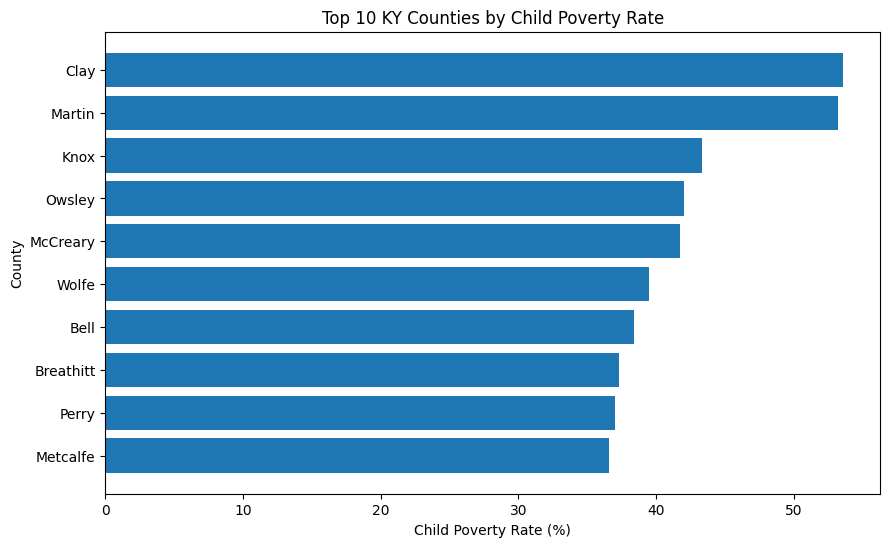

In [363]:
# Sort by child_poverty_pct and get top 10
top10_poverty = final_sql_df.sort_values("child_poverty_pct", ascending=False).head(10)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(top10_poverty["county"], top10_poverty["child_poverty_pct"] * 100)  # multiply by 100 for %
plt.xlabel("Child Poverty Rate (%)")
plt.ylabel("County")
plt.title("Top 10 KY Counties by Child Poverty Rate")
plt.gca().invert_yaxis()  # highest at top
plt.show()


Chart 2 — Vertical Bar Chart: Top KY Counties by Childcare Subsidies  
This chart shows the 15 Kentucky counties with the highest number of children receiving childcare subsidies in the latest available year.  
Sorting the data in descending order makes it easier to see which counties have the largest numbers.  

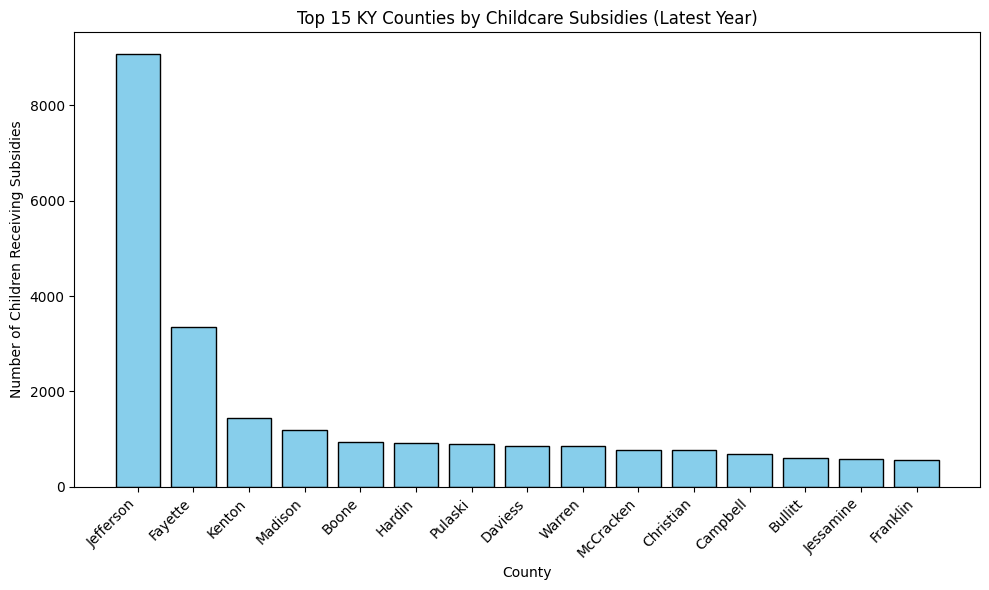

In [364]:
import matplotlib.pyplot as plt

# Sort by subsidies for better readability
sorted_df = final_df.sort_values(by="childcare_subsidies", ascending=False).head(15)  # top 15 counties

# Vertical bar chart
plt.figure(figsize=(10, 6))
plt.bar(sorted_df["county"], sorted_df["childcare_subsidies"], color="skyblue", edgecolor="black")
plt.title("Top 15 KY Counties by Childcare Subsidies (Latest Year)")
plt.xlabel("County")
plt.ylabel("Number of Children Receiving Subsidies")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


Chart 3 — Scatter Plot: Child Poverty vs. Graduation Rate  
This scatter plot compares each Kentucky county’s child poverty percentage with its high school graduation rate.  
The purpose is to look for possible relationships between poverty levels and graduation rates across counties.  
Each point represents a single county.  

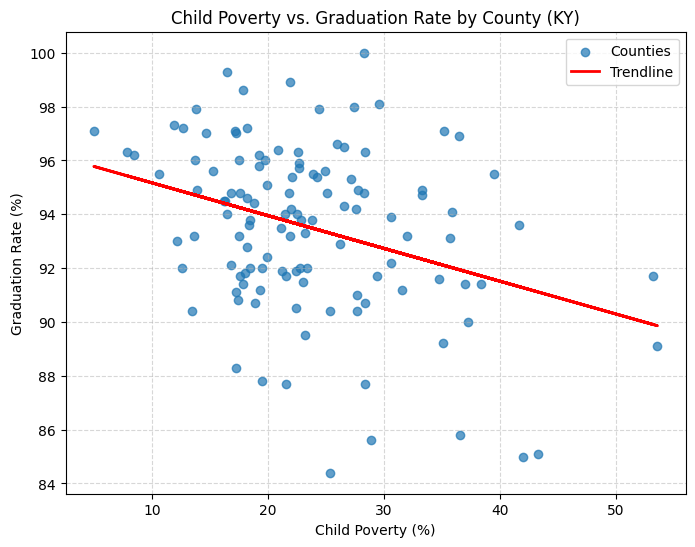

In [365]:
# Chart 3 — Scatter Plot with Trendline: Child Poverty vs. Graduation Rate
x = final_df["child_poverty_pct"] * 100  # Convert to %
y = final_df["grad_rate"]

plt.figure(figsize=(8, 6))
plt.scatter(x, y, alpha=0.7, label="Counties")

# Calculate and plot trendline
z = np.polyfit(x, y, 1)  # 1 = linear fit
p = np.poly1d(z)
plt.plot(x, p(x), color="red", linewidth=2, label="Trendline")

# Labels and title
plt.title("Child Poverty vs. Graduation Rate by County (KY)")
plt.xlabel("Child Poverty (%)")
plt.ylabel("Graduation Rate (%)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()

plt.show()


The trendline shows the general direction of the relationship. In this case, as poverty increases, graduation rates tend to drop slightly, which aligns with research on educational outcomes.

Project Summary

I wanted to see if there’s a link between child poverty, high school completion, childcare support, and graduation rates across Kentucky counties. I wanted to pull all three together to get a better view of what might be affecting education outcomes. This matters because the right support at the right time can make a big difference. If some areas are struggling more than others, that’s something worth paying attention to. 

To do this, I used three public datasets: County Health Rankings (for poverty and high school completion), Kentucky Kids Count (for childcare subsidies), and the KY Department of Education (for graduation rates). I cleaned them so they matched, stored them in a small SQLite database, and combined them using both Python and SQL and made 3 charts to look for patterns. 

What I found: graduation rates are generally high, but there are counties with more poverty that still lag behind. Some places have a lot more access to childcare subsidies than others in Kentucky.  